# Predict Sales

This project is a completed project where I will be doing to use of all techniques, Machine Learning, data mining and statistical applications. 

On the other hand, I will choose the system (relational or no - relational) most appropiate in order to achieve the efficiency.

The project is divided in 4 big steps:
1. Get Data.
2. Data Cleanning and Data Analysis.
3. Data trasformation for modelling
4. Modelling and Predicting

## 1. Get Data

* The source of the data will be, obviously, Internet, that is, I will scrape a web page, especifically, a e-commerce web page.

* Due that fact that not all features need are on internet, some features will be simulated, but keeping the economics logical. One  of them is the inverse relationship between prices and quantity demanded. 

* The database will make up by 
  * `user_data` or `costumer_data`
  * `product_data`  
  * `sales_data`

### Product Data

Here I will be using all tools for web scraping - crawling, and their packages, `Selenium`

In [1]:
import scraping

In [2]:
main_link = 'https://www.linio.com.pe'
page_html = scraping.DownloadHtml(main_link)

In [3]:
import re
from lxml.html import fromstring

tree = fromstring(page_html)
elements = tree.xpath('//li[@class="nav-item"]//a')

In [4]:
total_products = 0
for element in elements:
    grouped_link = '{}{}'.format(main_link, element.get('href'))
    html_page = scraping.DownloadHtml(grouped_link)
    tree = fromstring(html_page)
    elements_current = tree.xpath('//span[@class="results-quantity"]//text()')
    if elements_current: 
        group = re.search(r"/(?:c|cm)/(.+)",element.get('href'))
        group_1 = group.group(1)
        group_cap_1 = group_1.capitalize()
        print("> ",group_cap_1.ljust(38), elements_current[0])
        products_elements = re.sub(r'(\d{0,3})\,?(\d{1,3})\sproductos',r'\1\2' ,elements_current[0])
        if products_elements:
            total_products += float(products_elements)

>  Ofertas-solo-hoy                       63 productos
>  Productos-internacionales-en-peru      20,752 productos
>  Celulares-y-tablets                    385,175 productos
>  Tv-audio-y-video                       101,477 productos
>  Consolas-y-videojuegos                 48,672 productos
>  Computacion                            167,584 productos
>  Hogar                                  555,623 productos
>  Ferreteria                             257,050 productos
>  Electrodomesticos                      72,346 productos
>  Moda                                   652,819 productos
>  Moda/hombre                            157,501 productos
>  Belleza-y-cuidado-personal             167,821 productos
>  Salud-y-bienestar                      75,701 productos
>  Juguetes-ninos-y-bebes                 340,444 productos
>  Deportes                               217,605 productos
>  Despensa-vinos-y-gourmet               6,953 productos
>  Libros-y-peliculas/libros              16,167 pr

* There are approximately 3,158 074 products or less since one category can be a subcategory of the others, but this is a good aprox. although they are enought.

* I will take a sample of 500 products and the distribution will be random.

* Other considerations came from the code, specifically, the crawler code. I usually put a time boundaries and this case I will pass 3 minutes per category this will be the my populations of links by category.

In [5]:
from pathlib import Path
import json

In [6]:
class JsonNewDecoder(json.JSONDecoder):

    def default(self, obj):
        if isinstance(obj, set):
            return list(obj)
        return json.JSONDecoder.default(self, obj)

class JsonNewEncoder(json.JSONEncoder):

    def default(self, obj):
        if isinstance(obj, set):
            return list(obj)
        return json.JSONEncoder.default(self, obj)

if Path('url_to_scrape.json').exists():

    with open('url_to_scrape.json', 'rb') as reader:    
        links_total = json.load(reader, cls=JsonNewDecoder)
else:

    links_total = {}

    for element in elements:
        grouped_link = '{}{}'.format(main_link, element.get('href'))
        
        links = scraping.link_crawler(main_link, grouped_link, minutes=3)

        if re.search(r".*/(?:c|cm|sp)/(.+)", grouped_link):
            group = re.search(r".*/(?:c|cm|sp)/(.+)", grouped_link)
            group_1 = group.group(1)
            group_cap_1 = group_1.capitalize()
            
            links_total[group_cap_1] = list(links)
    
    with open('url_to_scrape.json', 'w') as writer:
        json.dump(links_total, writer, cls=JsonNewEncoder)
    

In [7]:
import numpy as np

In [8]:
np.random.seed(123)
random_numbers = np.random.randint(10, 50, size = len(links_total.keys()), )
random_propor = random_numbers/random_numbers.sum()
random_sample = np.multiply(random_propor,600).astype(int)

In [9]:
links_total_sample = []
for size, group_name in zip(random_sample, links_total.keys()):
    sample_data = list(np.random.choice(links_total[group_name], size = size))
    #for sample in sample_data:
    links_total_sample.extend(sample_data) #.append({group_name:sample}) #[group_name] = sample_data


In [11]:
import concurrent.futures
import time

t1 = time.perf_counter()
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(scraping.download_data_pages, links_total_sample)
t2 = time.perf_counter()

print(f'Finished in {t2 - t1} seconds')

Finished in 583.107144 seconds


In [12]:
def reader_json(root_file):
    with open(root_file, 'rb') as reader:
        return json.load(reader)

products_selenium = [ reader_json(file_json)  for file_json in Path('./DataPages').glob('*.json')]
products_selenium_select = list(np.random.choice(products_selenium, size = 500, replace=False))

In [13]:
from scipy.stats import beta
import numpy as np
import pandas as pd 

data_product = pd.DataFrame(
    dict(
        TimesBought = np.multiply(beta.rvs(a=1.1, b = 25.4, size=500, random_state = 123),50)),
    index = np.arange(10001, 10001+ 500)
    )
data_product.index.name = 'ProductId'
data_product.reset_index(inplace=True)

data_product_to_mongo = data_product[['ProductId']].astype(str).copy()
data_product_to_dict = data_product_to_mongo.apply(lambda x:dict(x),axis=1).values

In [14]:
complete_product_data = []
for produ_sel, dat_product in zip(products_selenium_select, data_product_to_dict):
    produ_sel.update(dat_product)
    complete_product_data.append(produ_sel)

In [18]:
from pymongo import MongoClient
from pathlib import Path
import json

mongo_uri = "mongodb://localhost"
client = MongoClient(mongo_uri)

db = client['to_model_sales']
collection = db['product_data']
collection.insert_many(complete_product_data)

### User Data

In [16]:
from scipy.stats import binom
import requests

data_users = pd.DataFrame({ 
    "TimesBought":binom.rvs(n = 20, p = 0.5, size = 1000),
    "CustomerId": np.arange(1001, 2001)} )

data_users.TimesBought = data_users.TimesBought/data_users.TimesBought.sum().copy()

response = requests.get('https://es.wikipedia.org/wiki/Categor%C3%ADa:Avenidas_de_Lima')
tree = fromstring(response.content)
avenidas = tree.xpath('//a[contains(text(),"Avenida ")]//text()')

data_users['Address'] = data_users.CustomerId.apply(lambda x: np.random.choice(avenidas) + ' ' +str(np.random.randint(100, 1400))).copy()
data_users['Age'] = np.round(beta.rvs(a= 10.5, b = 1.5,size = 1000 , random_state = 123)*50)
data_users['CellPhone'] = np.random.randint(900_000_000,1000_000_000, 1_000)

data_users[['CustomerId', 'Age', 'CellPhone']] = data_users[['CustomerId', 'Age', 'CellPhone']].astype(int).copy()

data_users_to_dict = data_users[['CustomerId' ,'Address', 'Age', 'CellPhone']].T.apply(lambda x:dict(x))
complete_user_data = list(data_users_to_dict.values)

In [17]:
from pymongo import MongoClient
from pathlib import Path
import json

mongo_uri = "mongodb://localhost"
client = MongoClient(mongo_uri)

db = client['to_model_sales']
collection = db['user_data']

collection.insert_many(complete_user_data)

### Sales Data

In [19]:
data_product_to_sales = data_product.set_index('ProductId')
data_product_times = dict(data_product_to_sales.TimesBought)

In [20]:
def GetItem():
    
    n = np.random.randint(1, 20)
    data_prod = []
    
    for _ in range(n):
        ProductId = np.random.choice(
            data_product_to_sales.index, 
            p = data_product_to_sales.TimesBought/data_product_to_sales.TimesBought.sum() )
            # p is the weights
            
        data_prod.append({
            "ProductId": int(ProductId), 
            "Amount": int(data_product_times[ProductId])})
    
    return data_prod

In [21]:
import datetime

def DatePoint():
        return (datetime.datetime(
            year= np.random.randint(2019, 2021), 
            month=np.random.randint(1, 12), 
            day=np.random.randint(1,28),  
            hour=np.random.randint(1, 24), 
            minute=np.random.randint(1, 60), 
            second=np.random.randint(1, 60)))

all_banks = ["Banco de Crédito del Perú", "Banco Pichincha", "BBVA", "Banco Falabella", "Banco Ripley"]
p_banks = [0.20, 0.05, 0.25, 0.3, 0.2]


def get_sales():
    data_current = {}
    CustomerId = np.random.choice(
        data_users.CustomerId, 
        p = data_users.TimesBought, replace=False)

    data_current["CustomerId"] = int(CustomerId)
    
    data_current["Date"]=DatePoint().isoformat()
    data_current["PaymentMethod"] = np.random.choice(["Cash", "Credit"], p = [0.5, 0.5], replace=False)
    
    if data_current["PaymentMethod"] == "Cash":
        data_current["PaymentMethod"] = {"Cash": np.random.choice(["Cash", "Debit"], p = [0.5, 0.5], replace=False)}
    else:
        data_current["PaymentMethod"] = {
            "Credit": {
                "Quotes": int(np.random.choice(list(range(1, 7)), p = [0.5, 0.15, 0.1, 0.1, 0.05, 0.1], replace=False)), 
                 "Back": np.random.choice(all_banks, p = p_banks, replace=False)}}
    data_current["Items"] = GetItem()
    return data_current

complete_sales_data = [get_sales() for _ in range(1000)]

In [22]:
from pymongo import MongoClient
from pathlib import Path
import json

mongo_uri = "mongodb://localhost"
client = MongoClient(mongo_uri)

db = client['to_model_sales']
collection = db['sales_data']

In [23]:
db.sales_data.insert_many(complete_sales_data)

In [119]:
for item_sales in complete_sales_data:
    try:
        collection.insert_one(item_sales)
    except:
        print(item_sales)

## 2. Data Cleaning and Data Analysis

In [57]:
all_fields = set()
for product_dict in complete_product_data:
    all_fields = all_fields.union(set(product_dict.keys()))
print("> All fields (for 1st stage): ",all_fields, sep = '\n')

> All fields (for 1st stage): 
{'tags', 'seller', 'discount', 'original-price', '_id', 'price-main-md', 'price-promotional', 'ProductId', 'title'}


In [ ]:
// ------------------------------
// Change the datatype of fields
// ------------------------------

db.product_data.find().forEach( 
    function (x) { 
        if (x['ProductId'] !== null){
            x['ProductId'] = new NumberInt(x['ProductId'])};
                
    db.product_data.save(x);
  });

db.sales_data.find().forEach( 
    function (x) { 
        if (x['Date'] !== null){
            x['Date'] = new ISODate(x['Date'])};
                
    db.sales_data.save(x);
  });

// ---------------------------------------------------------------
//  Compute the discount taking the difference between the prices.
// --------------------------------------------------------------

var pipeline = [
    {$set:{'division_to_discount':{$divide: ['$price-main-md', '$original-price']}}},
    {$set:{'discount':{$subtract: [1, '$division_to_discount']} }},
    {$unset:['division_to_discount'] }]

db.product_data.updateMany(
    {'original-price':{$gt:0}}, 
    pipeline)

// ---------------
// cluster by Age
// ---------------

var pipeline = [
    {$set:{"class_age":{$switch:
        {
            branches:[
                {
                    case:{$gte:["$Age", 50]},
                    then: ">=50"
                },
                {
                    case:{$gte:["$Age", 45]},
                    then: ">=45|<50"
                },
                {
                    case:{$gte:["$Age", 35]},
                    then: ">=35|<45"
                },
                {
                    case:{$gte:["$Age", 20]},
                    then: ">=20|<35"
                }
            ],
            default:"<20"
        }}}}
]

db.user_data.updateMany({'Age':{$gt:0}}, pipeline)

// --------------------------------------------------------
// computing the group by age cluster that more have bought 
// --------------------------------------------------------

var pipeline = [
        {$lookup: {
            from: "user_data",
            localField: "CustomerId", 
            foreignField: "CustomerId",
            as: "CustomerKey"}
        }, 
        { $unwind: "$CustomerKey"},
        {$lookup: {
            from: "product_data",
            localField: "Items.ProductId", 
            foreignField: "ProductId",
            as: "ProductKey"}}, 
        
        {$unwind: "$ProductKey"},
        {$unwind: "$Items"},
        {$group:
            {
                _id:{
                    "clas_age_customer":"$CustomerKey.class_age",
                    "category":{"$arrayElemAt":["$ProductKey.tags",0]}
                },
                "Total":{$sum:"$Items.Amount"} },
            },
        {$sort:{"Total":-1}}

    ]

db.sales_data.aggregate(pipeline)

// ------------------------------------------------------
//compute the sales amount grouping by score of sellers.
// ------------------------------------------------------

pipeline = [
    {$lookup: {
            from: "product_data",
            localField: "Items.ProductId", 
            foreignField: "ProductId",
            as: "ProductKey"}}, 
        
        {$unwind: "$ProductKey"},
        {$unwind: "$Items"},
    {
        "$group": { _id: "$ProductKey.seller.score", "Total":{$sum:"$Items.Amount"}
            
        }
        
    },
    {$sort: {"Total":-1}}
    ]
db.sales_data.aggregate(pipeline)
    

* This first analysis of the data points out the age group over 35 years are who make purschases (they are who work). This information can be useful for marketing area. And in a model this behavior should be showed.

* But the analysis can go deeper, searching the preferences by categories. To achive this, the next part is added. 
    ```mongodb
    {"category":{"$arrayElemAt":["$ProductKey.tags",0]}}
    ```
* The results show the age group over 35 years prefere the category `moda` over remaining.

* Also, the seller that have a good score (`5`) not always have the biggest sales.

In [ ]:
var pipeline = [
    {
        $group:{_id:{"$arrayElemAt":["$tags",0]}, "DiscountAvg": {$avg:"$discount"}}
    }, 
    {
        $sort:{"DiscountAvg":-1}
    }]

db.product_.aggregate(pipeline);

#### Basket Anaysis

In [1]:
import pandas as pd
import numpy as np
import re

In [28]:
name_file = r'./DataFromMongo/to_model_sales.sales_data.csv'
sales_data_from_mdb = pd.read_csv(name_file)

In [49]:
name_file = r'./DataFromMongo/to_model_sales.sales_data.csv'
sales_data_from_mdb = pd.read_csv(name_file)

sales_data_from_mdb['ProductId'] = (
    sales_data_from_mdb.Items.apply(lambda x:eval(x)).apply(lambda x:list(pd.DataFrame(x)['ProductId'])).copy())

sales_data_from_mdb['Amount'] = (
    sales_data_from_mdb.Items.apply(lambda x:eval(x)).apply(lambda x:list(pd.DataFrame(x)['Amount'])).copy())
    
sales_data_from_mdb.Date = pd.to_datetime(sales_data_from_mdb.Date)
sales_data_from_mdb.set_index('_id', inplace=True)

In [66]:
columns = ['ProductId', 'Amount']
to_concat = [sales_data_from_mdb[column].apply(lambda x:pd.Series(x)).stack().copy() for column in columns]
sales_prod_amount = pd.concat(to_concat, axis=1)
sales_prod_amount.columns = columns
sales_prod_amount.index = sales_prod_amount.index.droplevel(1)

In [71]:
sales_data_from_mdb_join = (
    sales_prod_amount.merge(
        sales_data_from_mdb[[ 'CustomerId', 'Date', 'PaymentMethod']], left_index=True, right_index=True))

In [75]:
sales_data_to_basket = sales_data_from_mdb_join[['ProductId', 'Date']].copy()
sales_data_to_basket.reset_index(inplace=True)
sales_data_to_basket.set_index('Date', inplace=True)

In [77]:
sales_data_to_basket.ProductId = sales_data_to_basket.ProductId.astype(int)

sales_data_to_basket_2019 = sales_data_to_basket.loc['2019'].copy()
sales_data_to_basket_2020 = sales_data_to_basket.loc['2020'].copy()

sales_to_basket_to_train = sales_data_to_basket_2019.reset_index(drop=True)

In [80]:
data_sales_to_basket = pd.crosstab(sales_to_basket_to_train._id, sales_to_basket_to_train.ProductId)

In [81]:
import basket

In [82]:
sales_basket = basket.Basket(data_sales_to_basket)
sales_basket.UniSupport(0.08).sort_values(ascending=False)

T(10134)    0.110204
T(10418)    0.097959
T(10222)    0.095918
T(10214)    0.083673
T(10321)    0.083673
T(10412)    0.081633
T(10493)    0.081633
Name: UniSupport, dtype: float64

In [83]:
sales_basket.PairSupport(0.01).sort_values(ascending=False)

T(A,B)
T(10134,10412)    0.020408
T(10412,10418)    0.020408
T(10134,10214)    0.016327
T(10134,10493)    0.012245
T(10222,10493)    0.012245
T(10412,10493)    0.012245
T(10134,10222)    0.010204
T(10214,10493)    0.010204
T(10222,10321)    0.010204
T(10222,10418)    0.010204
T(10321,10418)    0.010204
Name: PairSupport, dtype: float64

In [84]:
sales_basket.Confidence('A').sort_values(ascending=False)

T(A,B)/T(A)
T(10412,10418)/T(10412)    0.250000
T(10134,10412)/T(10134)    0.185185
T(10412,10493)/T(10412)    0.150000
T(10134,10214)/T(10134)    0.148148
T(10222,10493)/T(10222)    0.127660
T(10214,10493)/T(10214)    0.121951
T(10321,10418)/T(10321)    0.121951
T(10134,10493)/T(10134)    0.111111
T(10222,10321)/T(10222)    0.106383
T(10222,10418)/T(10222)    0.106383
T(10134,10222)/T(10134)    0.092593
Name: Confidence, dtype: float64

In [85]:
sales_basket.Lift().sort_values(ascending=False)

T(A,B)/T(A)T(B)
T(10412,10418)/T(10412)T(10418)    2.552083
T(10134,10412)/T(10134)T(10412)    2.268519
T(10412,10493)/T(10412)T(10493)    1.837500
T(10134,10214)/T(10134)T(10214)    1.770551
T(10222,10493)/T(10222)T(10493)    1.563830
T(10214,10493)/T(10214)T(10493)    1.493902
T(10134,10493)/T(10134)T(10493)    1.361111
T(10222,10321)/T(10222)T(10321)    1.271406
T(10321,10418)/T(10321)T(10418)    1.244919
T(10222,10418)/T(10222)T(10418)    1.085993
T(10134,10222)/T(10134)T(10222)    0.965327
Name: Lift, dtype: float64

* `Lift` ($k$) can be written  as $P(B|A) = k \; P(B)$. So,
  * If $k$>1, the effect of `A` on `B` is positive
  * If $k$=1, the effect of `A` on `B` is indiferent
  * If $k$<1, the effect of `A` on `B` is negative

* The items that have the hightest `Lift` are `10412` and `10418`, so these will be analyzed
* In order to this pupose it's necessary to import the table product_data

In [134]:
name_file = r'./DataFromMongo/to_model_sales.product_data.csv'
product_data_from_mdb = pd.read_csv(name_file)


In [113]:
product_data_from_mdb[product_data_from_mdb.ProductId.isin([10418, 10412])]

,title,tags,original-price,discount,price-main-md,seller,ProductId,price-promotional
411,Centro de Entretenimiento Casa Joven Eneza,hogar,199.0,0.100503,179.0,"{""score"":4.5,""link-low-md"":""HIPERMERCADOS TOTT...",10412,NaN
417,Artefacto Led 16w60k Blanco,hogar,91.9,0.500544,45.9,"{""score"":4.5,""link-low-md"":""Falabella""}",10418,NaN


* Individually, the item `10418 - Artefacto Led` has the probability `9%` that being add in basket in any transaction, but this probability increases at `25%` (was mulitply by `2.552083`, the `lift`) if previously the item `10412 - Centro de entretenimiento` was added at basket.

#### Join Data
* In order to build the model and contrast some hypothesis it's necessary normalize the data.
* For this purpose the data will be carry out to `Spark`.

In [ ]:
product_data_from_mdb.drop(columns=['_id'], inplace=True)
product_data_from_mdb.tags = product_data_from_mdb.tags.apply(lambda x:eval(x)).copy()
product_data_from_mdb.tags = product_data_from_mdb.tags.apply(lambda x:x[0])
score_seller = product_data_from_mdb.seller.apply(lambda x:pd.Series(eval(x), dtype='str'))
product_data_from_mdb_join = pd.concat([product_data_from_mdb, score_seller], axis = 1)
product_data_from_mdb_join.drop(columns=['seller'], inplace=True)

name_file = r'./DataFromMongo/to_model_sales.user_data.csv'
user_data_from_mdb = pd.read_csv(name_file)
user_data_from_mdb.drop(columns=['_id'], inplace=True)

In [136]:
join_data = (
    sales_data_from_mdb_join
    .merge(user_data_from_mdb, on = 'CustomerId')
    .merge(product_data_from_mdb_join, on = 'ProductId'))

In [140]:
join_data.to_parquet('join_data.parquet.gzip', compression='gzip')

In [11]:
import pandas as pd

In [49]:
df = pd.read_parquet('join_data.parquet.gzip')

In [57]:
from scipy.stats import uniform
import matplotlib.pyplot as plt

A bit of **Storytelling**

Text(0.59, 10, 'Top categories\n that do not have\n a discount')

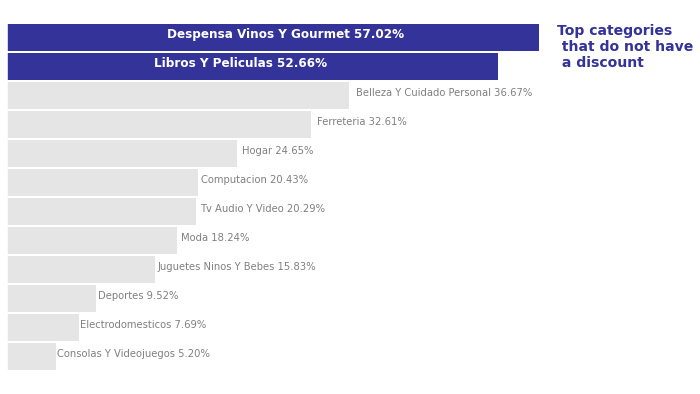

In [287]:
df_no_discount = df.groupby('tags')['discount'].agg(lambda x:x.isna().sum())
df_len = df.groupby('tags')['discount'].agg(lambda x:len(x))
no_discount_percent = (df_no_discount/df_len).sort_values(ascending=True)
no_discount_percent = no_discount_percent[no_discount_percent>0].copy()
no_discount_pct_label, no_discount_pct_val =  no_discount_percent.index, no_discount_percent.values

fig, ax = plt.subplots(figsize = (10, 7))

most_discount = ['despensa-vinos-y-gourmet', 'libros-y-peliculas']
colors = [(0, 0, 0.5, 0.8) if name in most_discount  else (0, 0, 0, 0.1)  for name in no_discount_pct_label ]

ax.barh(
    y = range(0, len(no_discount_pct_val)), width=no_discount_pct_val, height = 0.93,
    color = colors)

ax.tick_params(axis='both', bottom = False, left = False, labelleft=False,labelbottom=False,)

spines = ['right', 'top', 'left', 'bottom']
for spine in  spines:
    ax.spines[spine].set_color('white')

for index_, label, value in zip(range(14),no_discount_pct_label, no_discount_pct_val):
    if value>0:
        label_soul = label.title().replace('-', ' ')
        if label in most_discount:
            ax.text(value*0.3, index_, f'{label_soul} {value:.2%}' , color = 'white', 
            fontdict={'fontsize':12,  'weight' : 'semibold'})
        else:
            ax.text(value + value*0.02, index_, f'{label_soul} {value:.2%}', color = (0, 0, 0, 0.5))

ax.text(0.59, 10, 
        'Top categories\n that do not have\n a discount', 
        fontdict ={'fontsize':14, 'color': (0, 0, 0.5, 0.8), 'weight' : 'semibold' })

* We focus on the category `Despensa Vinos y Gourmet`

* What if we apply discount to above category? we can simulate it.

In [293]:
from scipy.stats import uniform

In [377]:
df_despensa_vinos = df.loc[df.tags == 'despensa-vinos-y-gourmet'].copy(deep=True)

# without discount:WO
df_despensa_vinos.loc[df_despensa_vinos.discount.isna(), 'Before'] = 'WO'

# with discount:W
df_despensa_vinos.loc[df_despensa_vinos.discount.notna(), 'Before'] = 'W' 

size = df_despensa_vinos.discount.isna().sum()
discount_uniform = uniform.rvs(loc = 0, scale = 1/3, size = size, random_state = 132)

df_despensa_vinos.loc[df_despensa_vinos.Before == 'WO', 'Amount'] = df_despensa_vinos.loc[df_despensa_vinos.Before == 'WO', 'Amount']*(1+discount_uniform) 
df_despensa_vinos.loc[df_despensa_vinos.Before == 'WO', 'discount'] = discount_uniform

In [391]:
df.loc[df.discount.notna(), 'Amount'].sum()

24220.0

In [376]:
df_despensa_vinos.loc[df_despensa_vinos.Before == 'WO', 'Amount'].mean()

4.008714596949891

In [352]:
df_despensa_vinos.Amount.mean()

4.114257640300859

* $\mu:$ mean of Sales Amount

* $H_0: \mu = 50$ 

In [346]:
discount_uniform.mean()

0.16621697575245678

In [323]:
df_despensa_vinos.columns

Index(['ProductId', 'Amount', 'CustomerId', 'Date', 'PaymentMethod', 'Address',
       'Age', 'CellPhone', 'class_age', 'title', 'tags', 'original-price',
       'discount', 'price-main-md', 'price-promotional', 'score',
       'link-low-md', 'Before'],
      dtype='object')

In [16]:
df
sample_size = 100
data_sample = df.groupby('tags').apply(lambda x:x.sample(sample_size))

In [22]:
df['discount'].isna().sum() 

0.2872245573812253

### PySpark

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [2]:
join_data_spark = spark.read.parquet('join_data.parquet.gzip')

Suppose that the company wants to reduce invetary, and for this purpose the team data science select a sample of products that will be the percentaje of discount.



In [3]:
join_data_spark.printSchema()

root
 |-- ProductId: double (nullable = true)
 |-- Amount: double (nullable = true)
 |-- CustomerId: long (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- CellPhone: long (nullable = true)
 |-- class_age: string (nullable = true)
 |-- title: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- original-price: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- price-main-md: double (nullable = true)
 |-- price-promotional: double (nullable = true)
 |-- score: string (nullable = true)
 |-- link-low-md: string (nullable = true)
 |-- __index_level_0__: long (nullable = true)



In [4]:
join_data_spark.select(['ProductID', 'Amount', 'tags']).show(2)

+---------+------+--------------------+
|ProductID|Amount|                tags|
+---------+------+--------------------+
|  10054.0|   1.0|juguetes-ninos-y-...|
|  10054.0|   1.0|juguetes-ninos-y-...|
+---------+------+--------------------+
only showing top 2 rows



In [10]:
join_data_spark.groupby(['tags']).agg({'Amount':'mean'}).show()

+--------------------+------------------+
|                tags|       avg(Amount)|
+--------------------+------------------+
|                moda| 2.765008576329331|
|belleza-y-cuidado...|3.7464622641509435|
|          ferreteria|2.5732758620689653|
|consolas-y-videoj...| 3.056179775280899|
|               hogar| 3.286079182630907|
|   salud-y-bienestar|3.1293260473588345|
|juguetes-ninos-y-...| 3.220440881763527|
|            deportes| 1.659310344827586|
| celulares-y-tablets|2.3653846153846154|
|         computacion| 2.497335701598579|
|   electrodomesticos| 5.611336032388664|
|    tv-audio-y-video| 3.206581352833638|
|despensa-vinos-y-...| 3.739130434782609|
|  libros-y-peliculas|2.9574468085106385|
+--------------------+------------------+

